# Tutorial

This notebook demonstrates the core functionality of Ferrobus, a high-performance transit routing library for Python.

## Setup

First, let's import the necessary libraries:

In [1]:
import datetime
import json
import time

import ferrobus
import geopandas as gpd
from shapely import wkt

In [3]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

## 1. Creating a Transit Model

The transit model is the core component that represents the transportation network. It combines GTFS transit data with OpenStreetMap road network data.

In [4]:
# Create a transit model with both GTFS and OSM data
model = ferrobus.create_transit_model(
    max_transfer_time=1800,  # 30 minutes as max transfer time
    osm_path="/home/chingiz/Rust/osm/roads_SZ.pbf",
    gtfs_dirs=[
        "/home/chingiz/Rust/py_rust/cascade/scripts/files/SPB2",
        "/home/chingiz/Rust/py_rust/cascade/scripts/files/spb-metro",
    ],
    date=datetime.date(2024, 4, 1),  # date for service filtering
)
# Display model info
print(model)

TransitModel with 8691 stops, 73775 routes and 2020348 trips


## 2. Creating Transit Points

Transit points represent geographic coordinates in the model, which can be used as origins or destinations for routing. Those pre-computed points allow for extremly fast routing queries with RAPTOR without the need to compute same walking paths from point to transit stops over and over again.

In [5]:
# Create transit points with different parameters
origin = ferrobus.create_transit_point(
    lat=60.04,
    lon=30.34,
    transit_model=model,
    max_walking_time=1200,  # 20 minutes maximum walking time
    max_nearest_stops=10,  # Consider up to 10 nearest transit stops
)

# Create a simpler transit point with default parameters
destination = ferrobus.create_transit_point(lat=59.93, lon=30.37, transit_model=model)

## 3. Finding Routes

The core functionality of Ferrobus is finding optimal routes between points.

In [6]:
# Find a route with basic parameters
start_time = time.perf_counter()
route = ferrobus.find_route(
    transit_model=model,
    start_point=origin,
    end_point=destination,
    departure_time=43200,  # 12:00 noon in seconds since midnight
    max_transfers=3,  # Allow up to 3 transfers
)
end_time = time.perf_counter()

# Display route information
print(f"Route found in {end_time - start_time:.3f} seconds")
print(f"Travel time: {route['travel_time_seconds'] / 60:.1f} minutes")
print(f"Transit time: {route['transit_time_seconds'] / 60:.1f} minutes")
print(f"Walking time: {route['walking_time_seconds'] / 60:.1f} minutes")
print(f"Number of transfers: {route['transfers']}")

Route found in 0.021 seconds
Travel time: 55.6 minutes
Transit time: 50.2 minutes
Walking time: 5.3 minutes
Number of transfers: 3


## 4. Detailed Journey Visualization

For a more detailed view, we can get the full journey with all legs (walking, transit) as GeoJSON for visualization.

In [7]:
# Get detailed journey information as GeoJSON
journey = ferrobus.detailed_journey(
    transit_model=model,
    start_point=origin,
    end_point=destination,
    departure_time=43200,  # 12:00 noon
    max_transfers=3,
)

# Convert to GeoDataFrame for visualization
journey_gdf = gpd.GeoDataFrame.from_features(json.loads(journey), crs=4326)

# Display journey information
print(f"Journey has {len(journey_gdf)} legs")

# Visualize the journey
journey_gdf.explore(
    column="leg_type",
    cmap="Set1",
    legend=True,
    tiles="CartoDB Dark Matter",
    legend_kwds={"colorbar": False, "loc": "upper right"},
)

Journey has 9 legs


## 5. Travel Time Matrix

Calculate travel times between multiple points.

In [ ]:
# Show part of the matrix (first 3×3 submatrix)
from statistics import mean

import numpy as np
import pandas as pd

grid = gpd.read_file("/home/chingiz/Rust/py_rust/cascade/scripts/SPB_grid.gpkg")

points = [
    ferrobus.create_transit_point(point.y, point.x, model)
    for point in grid.geometry.centroid.to_list()
]

# Calculate travel time matrix
matrix = ferrobus.travel_time_matrix(
    transit_model=model,
    points=points,
    departure_time=43200,  # 12:00 noon
    max_transfers=3,
)

# Display matrix dimensions
print(f"Matrix size: {len(matrix)} × {len(matrix[0])}")

# Convert to DataFrame for better visualization
matrix_np = np.array(matrix)
matrix_df = pd.DataFrame(matrix_np[:3, :3])
print("Travel times (seconds):")
print(matrix_df)


def compute_mean_if_enough_data(values, threshold=600):
    # Filter out None values
    valid_values = [v for v in values if v is not None]
    # Only compute the mean if we have enough valid values
    if len(valid_values) > threshold:
        return mean(valid_values)
    return None


# Compute the mean for each row in the matrix and store in grid["mean_travel_time"]
grid["mean_travel_time"] = [compute_mean_if_enough_data(row) for row in matrix]

grid.explore(
    column="mean_travel_time",
    cmap="RdYlGn_r",
    legend=True,
    legend_title="Mean Travel Time (seconds)",
    scheme="quantiles",
    legend_kwds={"colorbar": False, "loc": "upper right"},
    k=8,
)

Matrix size: 963 × 963
Travel times (seconds):
      0     1     2
0     0  2369  5399
1  2631     0  5560
2  5916  5969     0


## 6. Isochrones

Calculate isochrones (areas reachable within a given time) from a point.

In [10]:
# Create an isochrone index to speed up calculations
# The bounding box is defined as a WKT polygon string
bounding_box = grid.unary_union.convex_hull.wkt
index = ferrobus.create_isochrone_index(
    model, bounding_box, 9
)  # 9 represents the grid precision

# Calculate isochrones for different time thresholds
time_thresholds = [3600, 2400, 1800, 900]  # 30, 40, 50 minutes in seconds
isochrones = []

for threshold in time_thresholds:
    isochrone = ferrobus.calculate_isochrone(
        model,
        start=origin,
        departure_time=43200,  # 12:00 noon
        max_transfers=3,
        cutoff=threshold,
        index=index,
    )
    isochrones.append(isochrone)

# Convert to GeoDataFrame for visualization
isochrone_gdf = gpd.GeoDataFrame(
    {
        "time_threshold": [t / 60 for t in time_thresholds],  # Convert to minutes
        "geometry": [wkt.loads(poly) for poly in isochrones],
    },
    crs=4326,
)

# Visualize the isochrones
isochrone_gdf.explore(
    column="time_threshold",
    cmap="viridis_r",
    legend=True,
    legend_title="Reachable within (minutes)",
)

Snapped 9370 of 10459


In [16]:
pa_iso = ferrobus.calculate_percent_access_isochrone(
    model,
    start=origin,
    departure_range=(79200, 82800),  # From 22:00 to 23:00 in seconds
    sample_interval=60,
    max_transfers=3,
    cutoff=3600,
    index=index,
)

pa_iso = (
    gpd.GeoDataFrame.from_features(json.loads(pa_iso), crs=4326)
    .dissolve("percent_access")
    .reset_index()
)

pa_iso.explore(
    column="percent_access",
    cmap="RdYlGn",
    legend=True,
    legend_title="Percent chance of reaching this",
    scheme="natural_breaks",
    k=5,
    opacity=0.3,
    legend_kwds={"colorbar": False, "loc": "upper right"},
)

## 7. Advanced Feature: Pareto-Optimal Routes

Find multiple Pareto-optimal routes over a range of departure times.

Found 42 Pareto-optimal routes
   Departure Time (hours)  Travel Time (minutes)
0               12.026389              53.983333
1               12.059722              69.983333
2               12.126389              65.983333
3               12.209722              60.983333
4               12.226389              59.983333
5               12.343056              52.983333
6               12.359722              51.983333
7               12.459722              67.983333
8               12.493056              65.983333
9               12.559722              61.983333


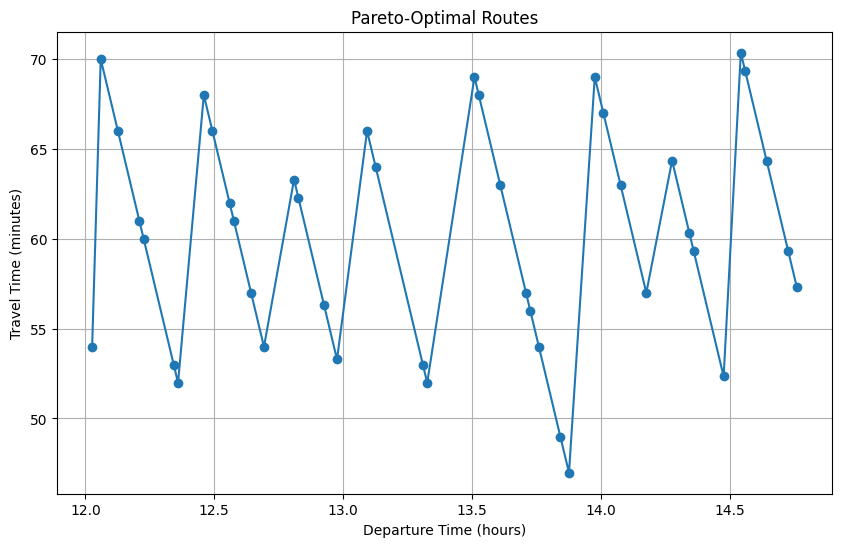

In [10]:
# Find Pareto-optimal routes over a range of departure times
pareto_results = ferrobus.range_multimodal_routing(
    transit_model=model,
    start=origin,
    end=destination,
    departure_range=(43200, 53200),  # From 12:00 to 13:00
    max_transfers=3,
)

# Extract travel times in minutes
travel_times = [t / 60 for t in pareto_results.travel_times()]
departure_times = [t / 3600 for t in pareto_results.departure_times()]

# Display results
print(f"Found {len(travel_times)} Pareto-optimal routes")

# Create a DataFrame for better visualization
pareto_df = pd.DataFrame(
    {"Departure Time (hours)": departure_times, "Travel Time (minutes)": travel_times}
)

print(pareto_df.sort_values("Departure Time (hours)").head(10))

# Plot results
import matplotlib.pyplot as plt  # noqa: E402

plt.figure(figsize=(10, 6))
plt.plot(departure_times, travel_times, marker="o", linestyle="-")
plt.xlabel("Departure Time (hours)")
plt.ylabel("Travel Time (minutes)")
plt.title("Pareto-Optimal Routes")
plt.grid(True)
plt.show()